In [1]:
'''
TODO 
As guidelines:
- https://github.com/ocatak/lstm_malware_detection/blob/master/deep_learnin_lstm_malware_detection.ipynb
- https://www.kaggle.com/code/hamzamanssor/detection-malware-using-machine-learning-models/notebook
As theory:
- https://y.com.sb/watch?v=YRhxdVk_sIs
- https://y.com.sb/playlist?list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1
As practical: 
- https://y.com.sb/watch?v=cOos6wRMpAU

'''

'\nTODO \nAs guidelines:\n- https://github.com/ocatak/lstm_malware_detection/blob/master/deep_learnin_lstm_malware_detection.ipynb\n- https://www.kaggle.com/code/hamzamanssor/detection-malware-using-machine-learning-models/notebook\nAs theory:\n- https://y.com.sb/watch?v=YRhxdVk_sIs\n- https://y.com.sb/playlist?list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1\nAs practical: \n- https://y.com.sb/watch?v=cOos6wRMpAU\n\n'

In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import shutil
from zipfile import ZipFile as zf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_validate,ParameterGrid,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
# from xgboost import XGBRFRegressor
from scipy.stats import randint
from keras.layers import Dense,Flatten,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras_tuner import HyperParameters,RandomSearch,Objective
import tensorflow as tf

'''
The following two 'detect_outliers' functions have been taken from 'Finding an outlier in a dataset using Python' by Krish Naik.
https://www.youtube.com/embed/rzR_cKnkD18
'''
outliers = []

def detect_outliers_std(df):
    threshold=3 # Can change
    mean = np.mean(df)
    std = np.std(df)

    for point in df:
        z_score = (point-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(point)
        
    return outliers
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

def calculate_correlation(df, column1, column2):
    correlation = df[column1].corr(df[column2])
    return correlation
def convert_days(days):
    years, days = divmod(days, 365) 
    months, days = divmod(days, 30)  
    print(f'Most extreme patient spent {years} years, {months} months and {days} days in the clinic')
def clean_useless_cols(df, y_label):
    print('#########################')
    print(f'starting with {df.columns.size} cols')
    print('#########################')
    print(df.corr().nlargest(df.columns.size, y_label)
          [y_label].sort_values(ascending=True))
    irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()
    ir_cols_list = irrelevant_cols[irrelevant_cols[y_label]].index
    print('\n#########################')
    print('irrelevant cols found (constants):')
    print('#########################')
    print(df[ir_cols_list].nunique())
    df.drop(ir_cols_list, axis=1, inplace=True)
    print('\n#########################')
    print(f'voila! set cleared. {df.columns.size} cols left to work with')
    print('#########################')

In [3]:
# unrar
SEED = 101

'''
Dataset taken from https://data.mendeley.com/datasets/25yjwbphn4/1

'''
with zf('Clinic.zip','r') as zin:
    zin.extractall()
    shutil.rmtree('25yjwbphn4-1')

In [4]:
# load data
df = pd.read_csv('Dataset.csv',encoding='utf-8')
medications = pd.read_csv('Medicationkey.csv')

df.rename(columns={'ID': 'Patient'}, inplace=True)
df.set_index('Patient',inplace=True)
medications.set_index('Medication', inplace=True)

# As-is, drug names have been shortened to alphabet letters, let's revert that
old_columns = medications.values.flatten()
new_columns = medications.index

for old, new in zip(old_columns, new_columns):
    df.rename(columns={old: new}, inplace=True)

In [5]:
# Get a sense of what features we are dealing with in this set
df.columns

Index(['GENDER', 'AGE', 'RACE/ETHNICITY', 'Diagnosis', 'MD', 'Assignment',
       'EMR', 'LOS', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE',
       'BUPROPION', 'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE',
       'CLONIDINE', 'DOXEPIN', 'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE',
       'FLUPHENAZINE', 'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL',
       'IMIPRAMINE', 'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE',
       'NORTRIPTYLINE', 'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE',
       'QUETIAPINE', 'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE',
       'ZIPRASIDONE', '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances'],
      dtype='object')

In [6]:
# Clean unconventional column names

# This is the equivalent of counting all drug columns suministered to the patient. We will later see how to use this
df.rename(columns={'# Administrations': 'Administrations'}, inplace=True)

df.rename(columns={'# Psychotropic Medications': 'Psychotropics'}, inplace=True)
df.rename(columns={'RACE/ETHNICITY': 'Ethnicity'}, inplace=True)

In [7]:
print('Checking for void values:')
df[df.columns[df.isnull().any()]].isnull().sum()

Checking for void values:


Assignment               41
Therapeutic Guidances    41
dtype: int64

In [8]:
'''
My strategy: 
Fill NaN with the most frequent value for each category
Note: mode() is the same as doing df[c].value_counts().index[0]
'''
df["Assignment"].fillna(df["Assignment"].mode().iloc[0], inplace=True)
df["Therapeutic Guidances"].fillna(df["Therapeutic Guidances"].mode().iloc[0], inplace=True)
# TODO is the above replacement worth it?

In [9]:
# We have a problem here: Multiple values for one column
pd.DataFrame(df['Diagnosis'].unique())

,0
0,"MDD, Recurrent, Unspecified"
1,"MDD, Single Episode, Severe With Psychotic Fea..."
2,Depressive Disorder NOS
3,"MDD, Single Episode,Severe Without Psychotic F..."
4,"MDD, Single Episode, Unspecified"
5,"MDD, Recurrent, Severe With Psychotic Features"
6,"MDD, Recurrent, Severe Without Psychotic Features"
7,"MDD, Recurrent, Moderate"
8,Mood Disorder NOS
9,Schizoaffective Disorder


c:\Users\W\.conda\envs\keras\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
c:\Users\W\.conda\envs\keras\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


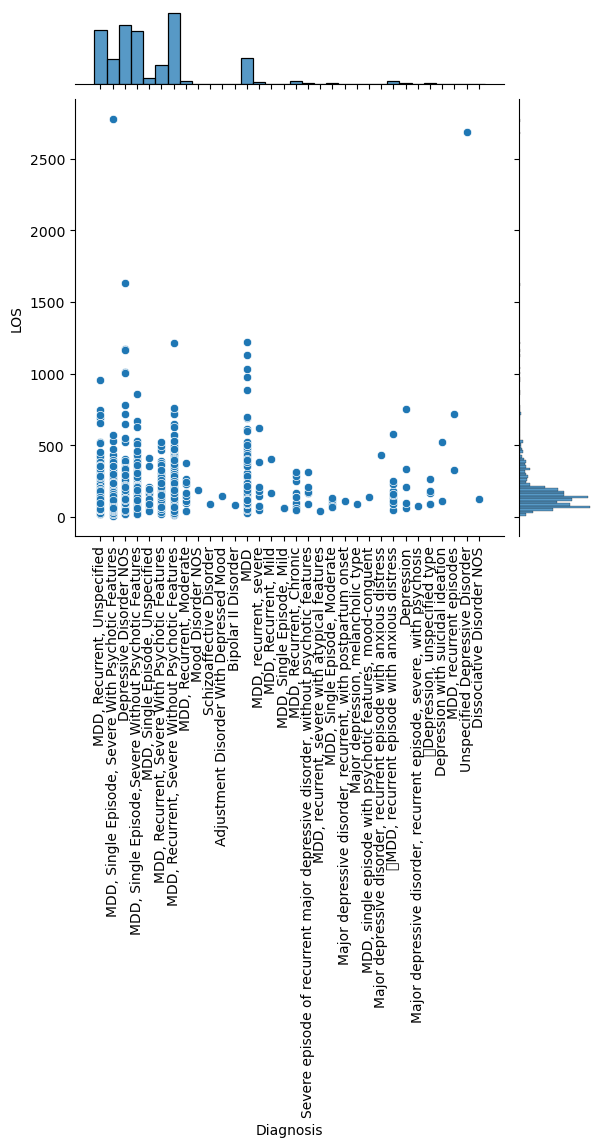

In [10]:
# Should we drop it?
sns.jointplot(data=df,x='Diagnosis',y='LOS')
plt.xticks(rotation=90);

In [11]:
df['Diagnosis'] = OrdinalEncoder().fit_transform(df['Diagnosis'].to_numpy().reshape(-1,1))
corr_rar = np.around(calculate_correlation(df,'RAR','Diagnosis'),4)
corr_los = np.around(calculate_correlation(df,'LOS','Diagnosis'),4)
print(f'RAR and Diagnosis are {corr_rar}% corr while LOS and Diagnosis are {corr_los}% correlated')

# Drop Diagnosis as it is not important to predict LOS
df.drop('Diagnosis',axis=1,inplace=True)

RAR and Diagnosis are 0.0186% corr while LOS and Diagnosis are -0.0041% correlated


In [12]:
df['MD'] = OrdinalEncoder().fit_transform(df['MD'].to_numpy().reshape(-1,1))
corr_rar = np.around(calculate_correlation(df,'RAR','MD'),4)
corr_los = np.around(calculate_correlation(df,'LOS','MD'),4)
print(f'RAR and MD are {corr_rar}% corr while LOS and MD are {corr_los}% correlated')

# Drop MD as it is not important to predict LOS
df.drop('MD',axis=1,inplace=True)

RAR and MD are -0.0349% corr while LOS and MD are 0.0866% correlated


In [13]:
df.groupby(['RAR']).count().transpose().head(1)

RAR,0,1
GENDER,1358,142


,LOS,Ethnicity_B,Ethnicity_L,Ethnicity_O/U,Ethnicity_W
LOS,1.000000,-0.062668,-0.118628,-0.004896,0.148104
Ethnicity_B,-0.062668,1.000000,-0.217214,-0.083441,-0.433118
Ethnicity_L,-0.118628,-0.217214,1.000000,-0.131254,-0.681301
Ethnicity_O/U,-0.004896,-0.083441,-0.131254,1.000000,-0.261716
Ethnicity_W,0.148104,-0.433118,-0.681301,-0.261716,1.000000


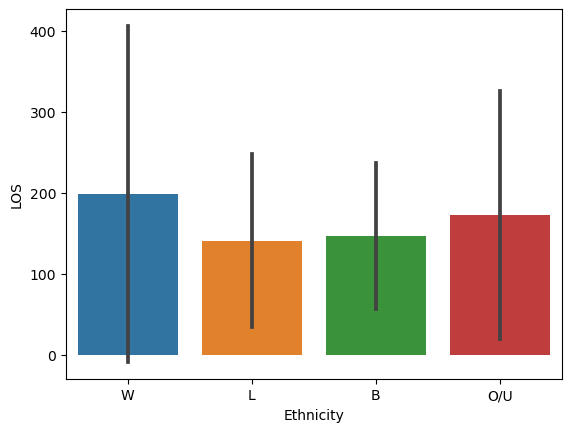

In [14]:
# Looking at more columns for influence...
# White patients tend to vary most and have on avg the majority of LOS
sns.barplot(data=df, x='Ethnicity', y='LOS', estimator=np.mean, errorbar='sd')
# However the Ethnicity coefficient is not that significant... 
# Nonetheless, 0.15 coefficient could potentially influence the outcome if the patient is of white ethnicity. 
race = df[['LOS','Ethnicity']]
pd.get_dummies(race).corr()

#########################
Discharged people : 1358 Recurrent people: 142 with a 9.56 times imbalance
#########################


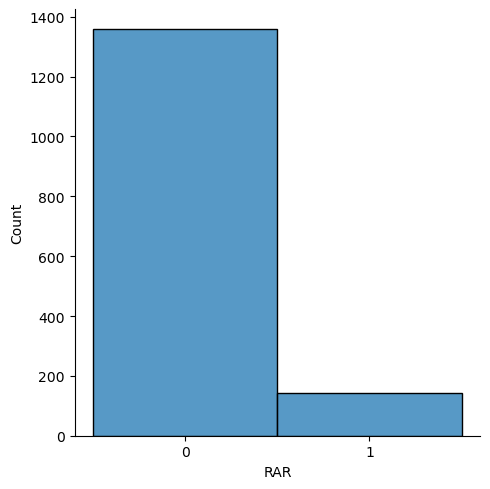

In [15]:
# Understanding what to predict: RAR or LOS ?

# Convert to string for plotting
df['RAR'] = df['RAR'].astype(str)
discharged_ppl,recurrent_ppl = df['RAR'].value_counts()
imbalance_ratio = np.around(discharged_ppl / recurrent_ppl,2)
print('#########################')
print(f'Discharged people : {discharged_ppl} Recurrent people: {recurrent_ppl} with a {imbalance_ratio} times imbalance')
print('#########################')
sns.displot(df['RAR'],bins=2)

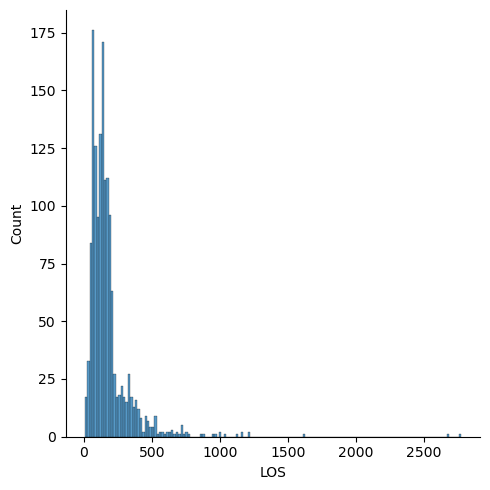

count    1500.000000
mean      176.520667
std       174.259930
min         6.000000
25%        90.000000
50%       138.000000
75%       191.250000
max      2776.000000
Name: LOS, dtype: float64


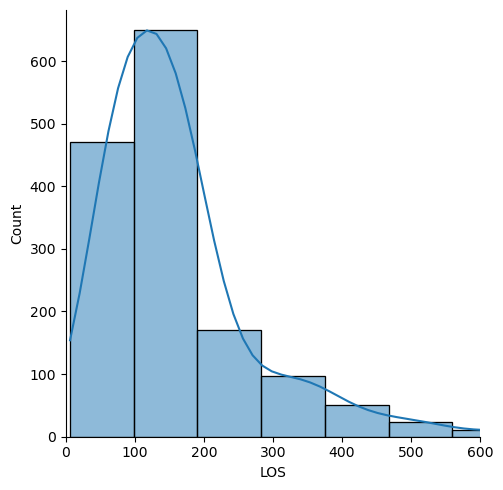

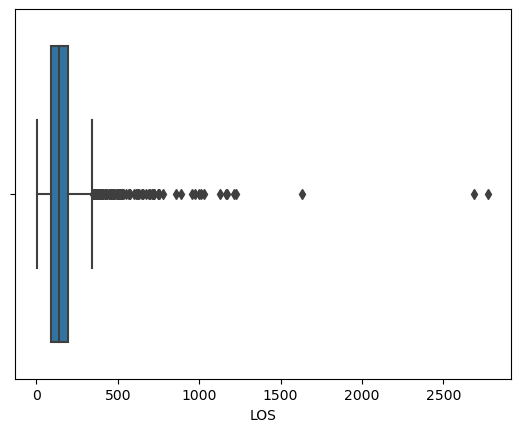

Most extreme patient spent 7 years, 7 months and 11 days in the clinic


In [16]:
# Since RAR is heavely imbalanced, let's try to focus on another outcome: The Length of Stay (LOS)

sns.displot(df['LOS'])
plt.show()
# Most patients don't stay more than 200 days
print(df['LOS'].describe())
sns.displot(data=df,x='LOS',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='LOS')
plt.show()
# Making sense of outliers
convert_days(df['LOS'].max())

In [17]:
outliers_std = sorted(detect_outliers_std(df['LOS']))
std_df = pd.DataFrame(outliers_std, columns=['outlier'])
outliers_iqr = sorted(detect_outliers_iqr(df['LOS']))
iqr_df = pd.DataFrame(outliers_iqr, columns=['outlier'])

# TODO start from IQR, but when you reach the range where std says there should be outliers, swap those IQR says at that range (they are more) with those std says and test 
# scores again

# Combined outliers
pd.concat([iqr_df, std_df]).drop_duplicates()


,outlier
0,349
1,350
2,351
3,352
4,353
...,...
137,1215
138,1223
139,1629
140,2685


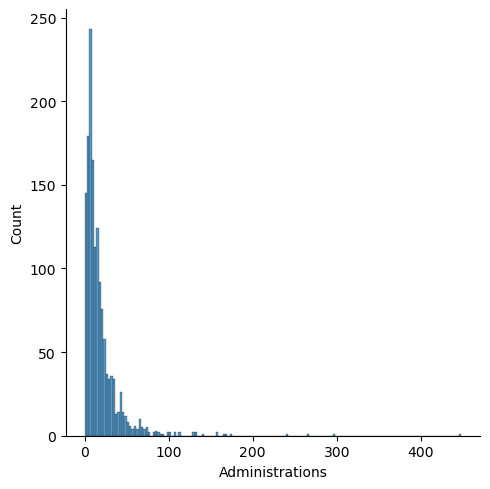

count    1500.000000
mean       18.322667
std        25.320176
min         0.000000
25%         6.000000
50%        12.000000
75%        22.000000
max       448.000000
Name: Administrations, dtype: float64


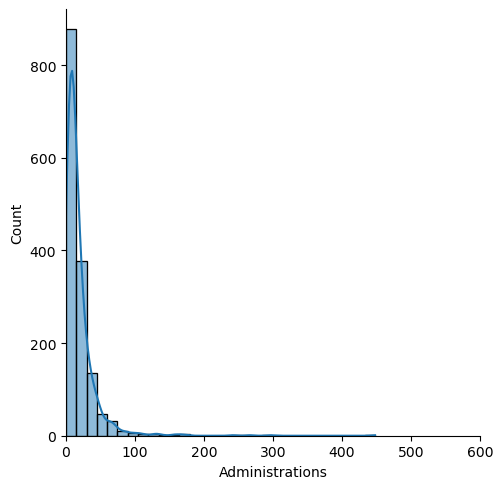

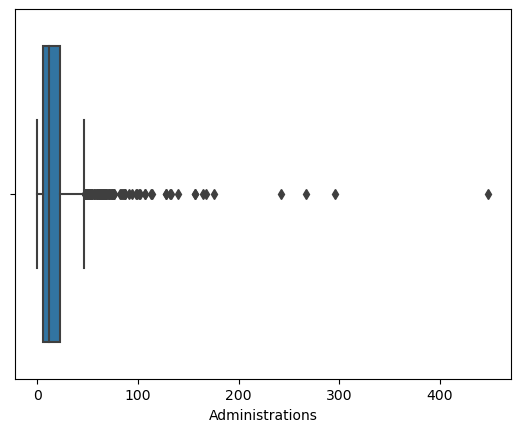

Most extreme patient had to take 448 medications


,GENDER,AGE,Ethnicity,Assignment,EMR,LOS,RAR,AMITRIPTYLINE,ARIPIPRAZOLE,ASENAPINE,...,PERPHENAZINE,QUETIAPINE,RISPERIDONE,SERTRALINE,TRAZODONE,VENLAFAXINE,ZIPRASIDONE,Psychotropics,Administrations,Therapeutic Guidances
Patient,,,,,,,,,,,,,,,,,,,,,
1060,F,66,W,G,E,2685,0,0,12,0,...,0,0,0,0,111,0,0,6,448,EG


In [18]:
# Now looking at amount of drugs taken in clinic
sns.displot(df['Administrations'])
plt.show()
# Most patients don't stay more than 200 days
print(df['Administrations'].describe())
sns.displot(data=df,x='Administrations',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='Administrations')
plt.show()
extreme_n_drugs = df['Administrations'].max()
print(f'Most extreme patient had to take {extreme_n_drugs} medications')
df[df['Administrations']==df['Administrations'].max()]

In [19]:
# Problematic columns for ML
for col in df.select_dtypes(include='object').columns:
    print(f'Column {col} has the following values:')
    print(df[col].value_counts())
    print('#########################')

# Except for the MD column, I would encourage doing a OneHotEncoding on each
# TODO solve categorical columns

Column GENDER has the following values:
F    769
M    731
Name: GENDER, dtype: int64
#########################
Column Ethnicity has the following values:
W      864
L      382
B      182
O/U     72
Name: Ethnicity, dtype: int64
#########################
Column Assignment has the following values:
G    1023
S     477
Name: Assignment, dtype: int64
#########################
Column EMR has the following values:
C    856
E    644
Name: EMR, dtype: int64
#########################
Column RAR has the following values:
0    1358
1     142
Name: RAR, dtype: int64
#########################
Column Therapeutic Guidances has the following values:
EG    1041
CT     393
TL      66
Name: Therapeutic Guidances, dtype: int64
#########################


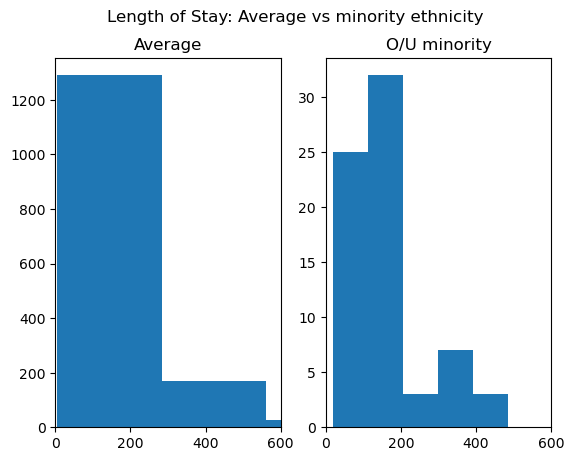

<Axes: xlabel='Ethnicity', ylabel='LOS'>

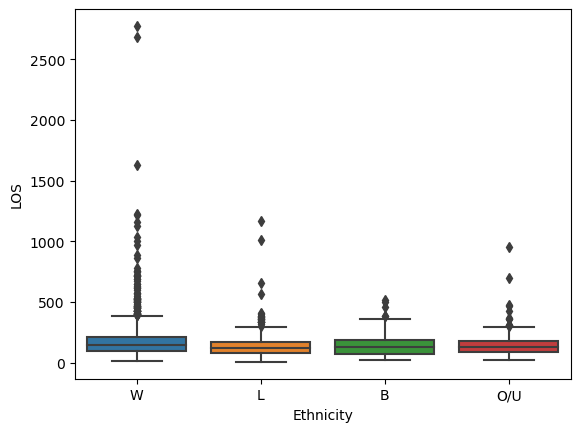

In [20]:
fig, ax = plt.subplots(ncols=2,nrows=1)
ax[0].hist(df['LOS'])
ax[0].set_xlim([0, 600])
ax[0].set_title('Average')
ax[1].hist(df[df['Ethnicity']=='O/U']['LOS'])
ax[1].set_title('O/U minority')
ax[1].set_xlim([0, 600])
fig.suptitle('Length of Stay: Average vs minority ethnicity')
plt.show()
sns.boxplot(x='Ethnicity',y='LOS',data=df)
# Since there is not much variance I decided to keep it

<Axes: xlabel='LOS', ylabel='Administrations'>

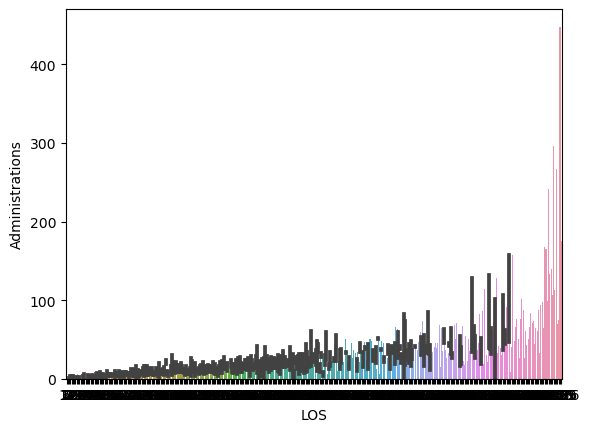

In [21]:
# Here we cannot see the number of people who fall into these ranges but rather only how total drug intake + days in clinic are  correlated
sns.barplot(data=df,x='LOS',y='Administrations')

<Axes: >

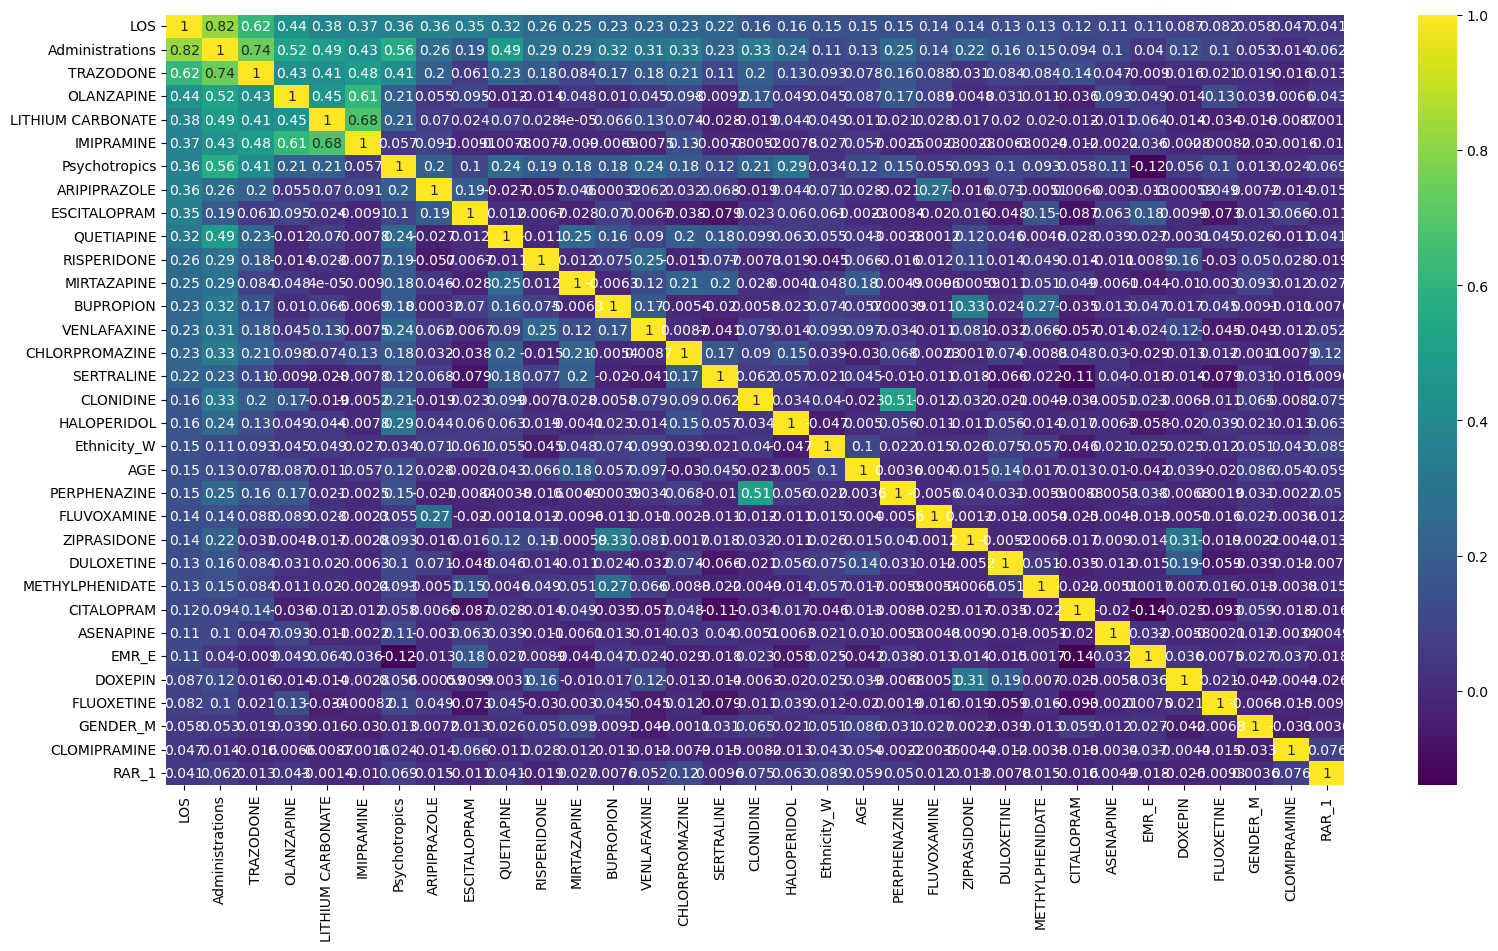

In [22]:
# There seems to be a correlation between the length of stay (LOS) and the amount of medications patients had to take
# Let's corroborate that presumption by plotting a heatmap!
df = pd.get_dummies(df,drop_first=True)
plt.figure(figsize=(19,10),dpi=100)
# Let's plot all but the 10 least significant features into a matrix and see how strong the correlations are
cols = df.corr().nlargest(df.shape[-1]-10, 'LOS')['LOS'].sort_values(ascending=False).index
sns.heatmap(df[cols].corr(),annot=True,cmap='viridis')

In [23]:
# Too many features, isn't it?
clean_useless_cols(df,'LOS')

#########################
starting with 43 cols
#########################
Ethnicity_L                -0.118628
Therapeutic Guidances_TL   -0.018722
Assignment_S               -0.015337
Ethnicity_O/U              -0.004896
Therapeutic Guidances_EG   -0.000822
GUANFACINE                  0.001724
PALIPERIDONE                0.024403
NORTRIPTYLINE               0.026556
FLUPHENAZINE                0.029459
AMITRIPTYLINE               0.036447
RAR_1                       0.041336
CLOMIPRAMINE                0.047341
GENDER_M                    0.057824
FLUOXETINE                  0.082462
DOXEPIN                     0.087144
EMR_E                       0.106368
ASENAPINE                   0.106835
CITALOPRAM                  0.116268
METHYLPHENIDATE             0.129360
DULOXETINE                  0.131695
ZIPRASIDONE                 0.135403
FLUVOXAMINE                 0.137158
PERPHENAZINE                0.145510
AGE                         0.147532
Ethnicity_W                 0.148104
H

In [24]:
n_leftover_patients = df[df['LOS']<=outliers_std[0]].to_numpy().shape[0]
n_starting_patients = df.shape[0]

percentage = (n_leftover_patients / n_starting_patients) * 100
print("Std-Drop: Percentage of patients retained: {:.2f}%".format(percentage))

n_leftover_patients = df[df['LOS']<=outliers_iqr[0]].to_numpy().shape[0]
n_starting_patients = df.shape[0]

percentage = (n_leftover_patients / n_starting_patients) * 100
print("IQR-Drop: Percentage of patients retained: {:.2f}%".format(percentage))

# Considering ... I have opted for dropping outliers above the value given by the x1.5 IQR calculation

# Drop the columns
df.drop(df[df['LOS'] > outliers_iqr[0]].index,inplace=True)
print(f"Now set has {df.shape[0]} patients")

Std-Drop: Percentage of patients retained: 98.47%
IQR-Drop: Percentage of patients retained: 90.60%
Now set has 1359 patients


# Reduction ft

In [25]:
# Given the analysis above, let's try to solve this problem the simplest way: 
simplest_df = df[['LOS','Administrations']]
simplest_df.head()

,LOS,Administrations
Patient,,
1,70,6
2,309,27
4,115,14
5,120,11
6,120,13


In [26]:
# Here we are taking the most simplistic model only for the purpose of selecting features. No hparam tuning, just a base to choose our fts!
clf = LinearRegression()

# Split the data (2ft)
X = simplest_df.drop('LOS', axis=1)
y = simplest_df['LOS'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, shuffle=True, test_size=0.3)

clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
mae = np.around(mean_absolute_error(y_test,yhat),2)

cscores = cross_validate(
    clf, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)


cv_mae = np.around(abs(cscores['test_score'].mean()),2)
print(f'LinearRegression scores {cv_mae} MAE with 5-fold CV and {mae} MAE without it (2 ft)')

LinearRegression scores 40.96 MAE with 5-fold CV and 37.64 MAE without it (2 ft)


In [27]:
'''
Not satisfied with the results? 
Let's see what is the optimal number of features to take in!
Possible feature selection
'''

# Split the data (all ft)
X = df.drop('LOS', axis=1)
y = df['LOS'].to_numpy()

# TODO ColumnTransformer


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, shuffle=True, test_size=0.3)

# KBest
k = SelectKBest(chi2, k=5).fit(X_train, y_train)
KX_train = k.transform(X_train)
KX_test = k.transform(X_test)

clf.fit(KX_train,y_train)
y_pred = clf.predict(KX_test)
# Calculate MAE
mae = np.around(mean_absolute_error(y_test, y_pred),2)
# Calculate RMSE
rmse = np.around(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'SelectKBest scores: {mae} MAE, {rmse} RMSE')

pd.DataFrame({'ft': X.columns, 'score': k.scores_}
             ).sort_values('score', ascending=0).transpose()

SelectKBest scores: 37.92 MAE, 49.32 RMSE


,3,32,30,16,14,24,15,1,18,10,...,35,31,39,41,34,37,38,33,36,40
ft,ASENAPINE,Administrations,ZIPRASIDONE,HALOPERIDOL,FLUVOXAMINE,PERPHENAZINE,GUANFACINE,AMITRIPTYLINE,LITHIUM CARBONATE,DULOXETINE,...,Ethnicity_O/U,Psychotropics,RAR_1,Therapeutic Guidances_TL,Ethnicity_L,Assignment_S,EMR_E,GENDER_M,Ethnicity_W,Therapeutic Guidances_EG
score,6576.183673,5893.055977,5884.772024,5729.334856,5370.002924,5303.274742,5213.723588,4998.785897,4739.420364,4719.139567,...,302.752518,253.617214,244.795648,195.263063,178.140796,169.629197,156.764891,143.424786,116.989168,69.557947


In [28]:
# Recurrent Feature Extraction 
rfe = RFE(clf,step=1).fit(X_train,y_train)
RX_train = rfe.transform(X_train)
RX_test = rfe.transform(X_test)

clf.fit(RX_train,y_train)
y_pred = clf.predict(RX_test)
# Calculate MAE
mae = np.around(mean_absolute_error(y_test, y_pred),2)
# Calculate RMSE
rmse = np.around(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'RFE says {X_train.columns[rfe.support_]} ({rfe.n_features_}) as best ft\'s to keep\n')
print(f'RFE scores: {mae} MAE, {rmse} RMSE')
pd.DataFrame({'ft':X.columns,'ranking':rfe.ranking_}).sort_values('ranking').transpose()

RFE says Index(['AMITRIPTYLINE', 'ASENAPINE', 'CITALOPRAM', 'CLOMIPRAMINE', 'CLONIDINE',
       'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE', 'FLUVOXAMINE', 'GUANFACINE',
       'METHYLPHENIDATE', 'MIRTAZAPINE', 'PALIPERIDONE', 'PERPHENAZINE',
       'SERTRALINE', 'Psychotropics', 'Administrations', 'Ethnicity_L',
       'Ethnicity_O/U', 'EMR_E', 'Therapeutic Guidances_TL'],
      dtype='object') (21) as best ft's to keep

RFE scores: 36.09 MAE, 48.19 RMSE


,20,38,35,34,32,31,27,24,23,19,...,39,5,29,21,13,28,2,40,9,0
ft,MIRTAZAPINE,EMR_E,Ethnicity_O/U,Ethnicity_L,Administrations,Psychotropics,SERTRALINE,PERPHENAZINE,PALIPERIDONE,METHYLPHENIDATE,...,RAR_1,CHLORPROMAZINE,VENLAFAXINE,NORTRIPTYLINE,FLUPHENAZINE,TRAZODONE,ARIPIPRAZOLE,Therapeutic Guidances_EG,DOXEPIN,AGE
ranking,1,1,1,1,1,1,1,1,1,1,...,13,14,15,16,17,18,19,20,21,22


RFECV scores: 35.93 MAE, 48.72 RMSE


Text(0.5, 0, 'ft')

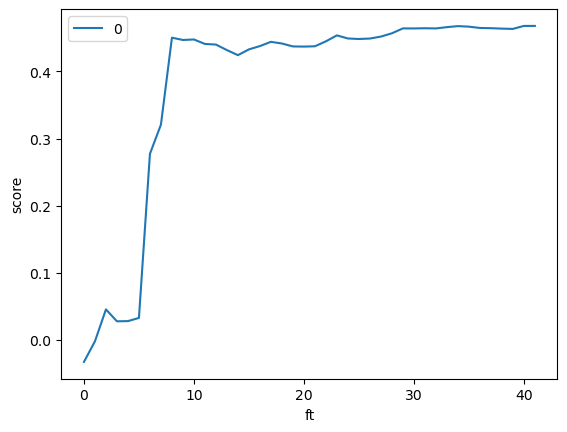

In [29]:
# Recurrent Feature Extraction with Cross-Validation
rfe = RFECV(clf,step=1).fit(X_train,y_train)
RX_train = rfe.transform(X_train)
RX_test = rfe.transform(X_test)

clf.fit(RX_train,y_train)
y_pred = clf.predict(RX_test)
# Calculate MAE
mae = np.around(mean_absolute_error(y_test, y_pred),2)
# Calculate RMSE
rmse = np.around(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'RFECV scores: {mae} MAE, {rmse} RMSE')
# Understanding where RFE CV hits the sweet spot number of features
dfplot = pd.DataFrame(rfe.cv_results_['mean_test_score']).plot()
# dfplot.set_xlim((0,16))
dfplot.set_ylabel('score')
dfplot.set_xlabel('ft')

In [30]:
# Lastly let's try PCA for dimensionality reduction
pca = PCA(n_components=2).fit(X_train)
PX_train = pca.transform(X_train)
PX_test = pca.transform(X_test)

clf.fit(PX_train,y_train)
y_pred = clf.predict(PX_test)
# Calculate MAE
mae = np.around(mean_absolute_error(y_test, y_pred),2)
# Calculate RMSE
rmse = np.around(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'PCA scores: {mae} MAE, {rmse} RMSE')

PCA scores: 37.66 MAE, 49.02 RMSE


In [31]:
'''ERRORS encountered on the way:

- The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Solution: Combine values so you don't end up with single y datapoint labels for very similar ranges OR don't use stratify during split!


- Getting low accuracy on a regression problem: Solution : Use MAE RMSE

- SimpleImputer for NaN causes loss of types when reconstructing to DataFrame

- Can't use StandardScaler before SelectKBest because input must be non negative

- ridge_regression CANNOT into pipeline, returns ndarray instead of estimator... use 'Ridge' instead
'''

"ERRORS encountered on the way:\n\n- The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.\nSolution: Combine values so you don't end up with single y datapoint labels for very similar ranges OR don't use stratify during split!\n\n\n- Getting low accuracy on a regression problem: Solution : Use MAE RMSE\n\n- SimpleImputer for NaN causes loss of types when reconstructing to DataFrame\n\n- Can't use StandardScaler before SelectKBest because input must be non negative\n\n- ridge_regression CANNOT into pipeline, returns ndarray instead of estimator... use 'Ridge' instead\n"

# Models

In [32]:
# Instantiate the models and the random search
X = StandardScaler().fit_transform(X)
y = df['LOS']

# Following guidelines from: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
clf1 = Ridge(random_state=SEED)
clf2 = SVR()
clf3 = XGBRFRegressor(tree_method='gpu_hist',gpu_id=-1)
clf4 = ElasticNet(random_state=SEED)
clf5 = Lasso(random_state=SEED)
clf6 = MLPRegressor(random_state=SEED)

# Define the hyperparameter search space
param_grid1 = {
    'clf': [clf1],
    'clf__alpha': [0.1, 1.0, 10.0],
    'clf__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'clf__tol': [0.0001, 0.001, 0.01]
}
param_grid2 = {
    'clf': [clf2],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto'],
    'clf__epsilon': [0.01, 0.1, 1.0]
}
param_grid3 = {
    'clf': [clf3],
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__gamma': [0.0, 0.1, 0.2],
    'clf__reg_alpha': [0.0, 0.1, 0.2],
    'clf__reg_lambda': [0.0, 0.1, 0.2]
}
param_grid4 = {
    'clf': [clf4],
    'clf__alpha': [0.1, 1.0, 10.0],
    'clf__l1_ratio': [0.25, 0.5, 0.75],
    'clf__tol': [1e-2, 1e-3, 1e-4, 1e-5]
}
param_grid5 = {
    'clf': [clf5],
    'clf__alpha': [0.1, 1.0, 10.0],
    'clf__tol': [0.0001, 0.001, 0.01]
}
param_grid6 = {
    'clf': [clf6],
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'clf__activation': ['relu', 'tanh'],
    'clf__solver': ['adam', 'sgd'],
    'clf__learning_rate': ['constant', 'adaptive'],
    'clf__learning_rate_init': [0.001, 0.01, 0.1],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__max_iter': [100, 200, 500],
    'clf__early_stopping': [True, False]
}
pipe = Pipeline([('clf', clf1)])
param_grid = [param_grid1, param_grid2, param_grid3, param_grid4, param_grid5,param_grid6]

# Begin search
random_search = RandomizedSearchCV(
    pipe, param_grid, cv=30, n_jobs=-1, random_state=SEED, scoring='neg_mean_absolute_error', verbose=4)

# RAW untouched data
# df = pd.read_csv('Dataset.csv',encoding='utf-8')
# X = pd.get_dummies(df.drop('LOS',axis=1),drop_first=True)

random_search.fit(X, y)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


c:\Users\W\.conda\envs\keras\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
210 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\W\.conda\envs\keras\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\W\.conda\envs\keras\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\W\.conda\envs\keras\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\W\.conda

RandomizedSearchCV(cv=30,
                   estimator=Pipeline(steps=[('clf', Ridge(random_state=101))]),
                   n_jobs=-1,
                   param_distributions=[{'clf': [Ridge(random_state=101)],
                                         'clf__alpha': [0.1, 1.0, 10.0],
                                         'clf__solver': ['auto', 'svd',
                                                         'cholesky', 'lsqr',
                                                         'sparse_cg', 'sag',
                                                         'saga'],
                                         'clf__tol': [0.0001, 0.001, 0.01]},
                                        {'clf': [SVR()],
                                         'clf__C': [0.1, 1.0, 10.0],
                                         'clf__epsilon': [0.01, 0.1, 1.0],...
                                         'clf__activation': ['relu', 'tanh'],
                                         'clf__alpha': [0.0001, 0.001, 0.01],
                                         'clf__early_stopping': [True, False],
                                         'clf__hidden_layer_sizes': [(50,),
                                                                     (100,),
                                                                     (50, 50),
                                                                     (100,
                                                                      100)],
                                         'clf__learning_rate': ['constant',
                                                                'adaptive'],
                                         'clf__learning_rate_init': [0.001,
                                                                     0.01,
                                                                     0.1],
                                         'clf__max_iter': [100, 200, 500],
                                         'clf__solver': ['adam', 'sgd']}],
                   random_state=101, scoring='neg_mean_absolute_error',
                   verbose=4)

In [33]:
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", np.around(abs(random_search.best_score_),2),'MAE')

Best Hyperparameters:  {'clf__solver': 'adam', 'clf__max_iter': 200, 'clf__learning_rate_init': 0.1, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (100, 100), 'clf__early_stopping': True, 'clf__alpha': 0.0001, 'clf__activation': 'relu', 'clf': MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 100),
             learning_rate_init=0.1, random_state=101)}
Best Score:  32.85 MAE


# Keras

In [3]:
# Check GPU 
import tensorflow as tf;tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
'''Attention! 
The following code (only this snippet) has been taken from the Keras Documentation
See: https://keras.io/guides/keras_tuner/getting_started/ for retreiving its original source (and authors). NOT of my authority!''' 
def build_model(hp):
    model = Sequential()
    model.add(Flatten())
    model.add(
        Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
    model.add(Dense(1))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mean_absolute_error",
    )
    return model

# Define the objective for regression
# objective = Objective("val_mae", direction="min")

# def build_model(n_hidden,acti,l_rate,i_shape):
#     model = Sequential()
#     model.add(Flatten())
#     model.add(
#         Dense(
#             # Tune number of units.
#             units=n_hidden,
#             # Tune the activation function to use.
#             activation=acti,
#             input_shape=i_shape
#         )
#     )
#     model.add(Dense(1))
#     # Define the optimizer learning rate as a hyperparameter.
#     learning_rate = l_rate
#     model.compile(
#         optimizer=Adam(learning_rate=learning_rate),
#         loss="mean_absolute_error",
#         metrics=[MeanAbsoluteError()],
#     )
#     return model

history = build_model(HyperParameters()).fit(X_train,y_train,validation_data=(X_test,y_test),verbose=4)
history.history

{'loss': [128.2665557861328],
 'mean_absolute_error': [128.2665557861328],
 'val_loss': [128.4734344482422],
 'val_mean_absolute_error': [128.4734344482422]}

In [ ]:
tuner = RandomSearch(
    hypermodel=build_model,
    objective='loss',
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)
tuner.search(X_train, y_train, epochs=2, validation_data=(X_test, y_test))
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, X.shape[-1]))
best_model.summary()
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train, y_test))
model.fit(x=X, y=y, epochs=1)

Trial 3 Complete [00h 00m 03s]
loss: 44.648847579956055

Best loss So Far: 41.98640823364258
Total elapsed time: 00h 00m 09s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 480)               20640     
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 481       
                                                                 
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
43/43 [==============